In [1]:
import numpy
import sys
import skimage.data
import matplotlib

#### Convolution
In mathematics convolution is a mathematical operation on two functions to produce a third function which express how shape of one modified by others. The term refers to both result function and the process of computing it.
 
As we can see in the below image the we are doing matrix multiplication which includes **current selected region and filter** and summing it.
<img src="img/edge_detection.png"/>
Current Region ( **curr_region** variable in below function) is calculated from left to right and top to bottom. Mooving of region is also dependent on strides we are using **stride as 2**.
##### Stride
Stride controls how the filter convolves around the input volume. In the example below, the first part filter convolves around by shifting one uints at a time. The amount by which the filter shifts is the stride. Lets check the example below<br>
- input size = **7 * 7** 
- filter size = **3 * 3**
<img  src="img/stride_examples.png"/>
As you can see in above example the output volume is **5 * 5** and **3 * 3** in first part and second part respectively.*Note: output volume shrinks as stride increased from 1 to 2 * . Notice that if we tried to set our stride to 3, then we’d have issues with spacing and making sure the receptive fields fit on the input volume. <br>
Formla for calculating size of output matrix (Output Volume) is as follows<br>
$ (height - 2padding - filter size / stride - 1 ) * (width - 2padding - filter size / stride - 1 ) $<br>
In our case we are clipping this output matrix as we have initilised matrix with size of image size <br>

`result[numpy.uint16(filter_size/2.0):result.shape[0]-numpy.uint16(filter_size/2.0), 
        numpy.uint16(filter_size/2.0):result.shape[1]-numpy.uint16(filter_size/2.0)]`

In [2]:
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = numpy.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in numpy.uint16(numpy.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        for c in numpy.uint16(numpy.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filer sizes is the most tricky part of convolution.
            """
            curr_region = img[r-numpy.uint16(numpy.floor(filter_size/2.0)):r+numpy.uint16(numpy.ceil(filter_size/2.0)), 
                              c-numpy.uint16(numpy.floor(filter_size/2.0)):c+numpy.uint16(numpy.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = numpy.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[numpy.uint16(filter_size/2.0):result.shape[0]-numpy.uint16(filter_size/2.0), 
                          numpy.uint16(filter_size/2.0):result.shape[1]-numpy.uint16(filter_size/2.0)]
    return final_result

Main Convolution function with 2 paramaters image and filter, this function is just a wrapper function which calls function **conv_** where all the calculation of convolution is done.

In [3]:
def conv(img, conv_filter):
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

#### Pooling 
Poolng layer is also refered to as downsampling layer. The objective is to downsample input representation, reducing its dimensionality and allowing for assumptions to be made about feature contained in the sub region binned.
There are mainly two types of Pooling
- Max Pooling
- Avg Pooling
We are using max pooling in our script. example of max pooling is as follows.
<img src="img/max_pooling.png"/>
*(Source: Stanford's CS231n github)* <br>
For each of the regions represented by the filter, we will take the max of that region and create a new, output matrix where each element is the max of a region in the original input.
<br>
Calculation size of output matrix in pooling
Hyperparamaters:
- f : Filter Size
- s : stride 
<br>
Max or Avg Pooling 
$ pool size = nH * nW * nC $
$ (height - f / s - 1 ) * (width - f / s - 1 ) * nC $<br>
In our case we calculated **pool_out** as follows

`pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride+1),
            numpy.uint16((feature_map.shape[1]-size+1)/stride+1),
            feature_map.shape[-1]))`

In [4]:
def pooling(feature_map, size=2, stride=2):
    #Preparing the output of the pooling operation.
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride+1),
                            numpy.uint16((feature_map.shape[1]-size+1)/stride+1),
                            feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in numpy.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in numpy.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = numpy.max([feature_map[r:r+size,  c:c+size]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

#### ReLU (Rectified Linear Units) Layers
  After each conv layer, it is convention to apply a nonlinear layer (or **activation layer**) immediately afterward.The purpose of this layer is to introduce nonlinearity to a system that basically has just been computing linear operations during the conv layers (just element wise multiplications and summations).In the past, nonlinear functions like tanh and sigmoid were used, but researchers found out that ReLU layers work far better because the network is able to train a lot faster (because of the computational efficiency) without making a significant difference to the accuracy. It also helps to alleviate the vanishing gradient problem, which is the issue where the lower layers of the network train very slowly because the gradient decreases exponentially through the layers (Explaining this might be out of the scope of this, but see <a href="https://en.wikipedia.org/wiki/Vanishing_gradient_problem">here</a> and <a href="https://www.quora.com/What-is-the-vanishing-gradient-problem">here</a> for good descriptions). The ReLU layer applies the function  $ f(x) = max(0, x) $ to all of the values in the input volume. In basic terms, this layer just changes all the negative activations to 0.This layer increases the nonlinear properties of the model and the overall network without affecting the receptive fields of the conv layer.
*(Source: adeshpande3.github.io)*

In [5]:
def relu(feature_map):
    #Preparing the output of the ReLU activation function.
    relu_out = numpy.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in numpy.arange(0,feature_map.shape[0]):
            for c in numpy.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = numpy.max([feature_map[r, c, map_num], 0])
    return relu_out

As Our Function declaration is lets move on to run convolution layer.
### Reading input image
initialization of Image.
- Fetching image data from skimage
- Convert image to gray

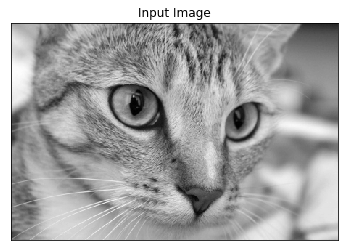

In [6]:
# Reading the image
img = skimage.data.chelsea()

# Converting the image into gray.
img = skimage.color.rgb2gray(img)

# Graphing results
# Show Input Image
fig0, ax0 = matplotlib.pyplot.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
matplotlib.pyplot.savefig("in_img.png", bbox_inches="tight")
matplotlib.pyplot.show()
matplotlib.pyplot.close(fig0)

## First Convolution laeyer
### Preparing filters
The following code prepares the filters bank for the first conv layer (l1 for short):
A zero array is created according to the number of filters and the size of each filter. **2** filters of size **3x3** are created that is why the zero array is of size *(2=num_filters, 3=num_rows_filter, 3=num_columns_filter)*. Size of the filter is selected to be 2D array without depth because the input image is gray and has no depth (i.e. 2D ). If the image is RGB with 3 channels, the filter size must be **(3, 3, 3=depth)**.


In [7]:
l1_filter = numpy.zeros((2,3,3))

Above step creates blank array of **0** of size 2 * 3 * 3, these can be repaced with actual array as follows for vertical and horizanal edge

In [8]:
#Vertical Edge Detection Filter
l1_filter[0, :, :] = numpy.array([[[-1, 0, 1], 
                                   [-1, 0, 1], 
                                   [-1, 0, 1]]])
#Horizontal Edge Detection Filter
l1_filter[1, :, :] = numpy.array([[[1,   1,  1], 
                                   [0,   0,  0], 
                                   [-1, -1, -1]]])

### Conv Layer
 After preparing the filters, next is to convolve the input image by them. The next line convolves the image with the filters bank using a function called conv:

In [9]:
l1_feature_map = conv(img, l1_filter)  

Filter  1
Filter  2


### ReLU Layer
The ReLU layer applies the ReLU activation function over each feature map returned by the conv layer. It is called using the relu function according to the following line of code:

In [10]:
l1_feature_map_relu = relu(l1_feature_map)

### Max Pooling Layer
The max pooling layer accepts the output of the ReLU layer and applies the max pooling operation according to the following line:

In [11]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)  


** Display Output of First Layer**



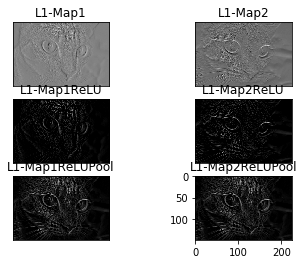

In [12]:
# Display Output of First Layer
print("\n** Display Output of First Layer**\n")
fig1, ax1 = matplotlib.pyplot.subplots(nrows=3, ncols=2)
ax1[0, 0].imshow(l1_feature_map[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_map[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_map_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_map_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

matplotlib.pyplot.savefig("L1.png", bbox_inches="tight")
matplotlib.pyplot.show()
matplotlib.pyplot.close(fig1)

## Second Convolution layer
### Stacking Layers
Up to this point, the CNN architecture with conv, ReLU, and max pooling layers is complete. There might be some other layers to be stacked in addition to the previous ones as below.

The Second conv layer uses 3 filters with their values generated randomly. That is why there will be 3 feature maps resulted from such conv layer. This is also the same for the successive ReLU and pooling layers.

In [13]:
# Second conv layer
l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 2**")
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
print("\n**ReLU**")
l2_feature_map_relu = relu(l2_feature_map)
print("\n**Pooling**")
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)
print("**End of conv layer 2**\n")


**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**




** Display Output of Second Layer**



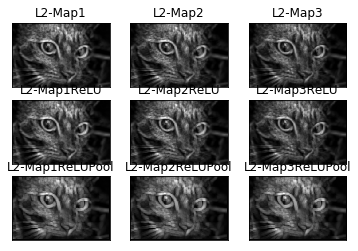

In [14]:
# Display Output of Second Layer
print("\n** Display Output of Second Layer**\n")
fig2, ax2 = matplotlib.pyplot.subplots(nrows=3, ncols=3)
ax2[0, 0].imshow(l2_feature_map[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_map[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_map[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_map_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_map_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_map_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_map_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")

matplotlib.pyplot.savefig("L2.png", bbox_inches="tight")
matplotlib.pyplot.show()
matplotlib.pyplot.close(fig2)

## Third Convolution Layer
The Third conv layer accepts just a single filter. That is why there is only one feature map.

In [15]:
# Third conv layer
l3_filter = numpy.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 3**")
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
print("\n**ReLU**")
l3_feature_map_relu = relu(l3_feature_map)
print("\n**Pooling**")
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)
print("**End of conv layer 3**\n")


**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**




** Display Output of Second Layer**



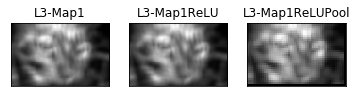

In [16]:
# Display Output of Second Layer
print("\n** Display Output of Second Layer**\n")
fig3, ax3 = matplotlib.pyplot.subplots(nrows=1, ncols=3)
ax3[0].imshow(l3_feature_map[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_map_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")

matplotlib.pyplot.savefig("L3.png", bbox_inches="tight")
matplotlib.pyplot.show()
matplotlib.pyplot.close(fig3)

### Note
The output of each previous layer is input to next layer.For example, such lines accepts the previous outputs as their inputs.
`l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)`